## This notebook does the following 
* **Retrieves and prints basic data about a movie (title entered by user) from the web (OMDB database)**
* **If a poster of the movie could be found, it downloads the file and saves at a user-specified location**
* **Finally, stores the movie data in a local SQLite database**

In [23]:
import urllib.request, urllib.parse, urllib.error
import json

### Gets the secret API key (you have to get one from OMDB website and use that, 1000 daily limit) from a JSON file, stored in the same folder

with open('APIkeys.json') as f:
    keys = json.load(f)

omdbapi = keys['OMDBapi']

In [24]:
# including the personal token in all the request to the API

omdbapi= 'cba04cc6'
serviceurl = 'http://www.omdbapi.com/?'
apikey = '&apikey='+omdbapi

### Function for printing a JSON dataset

In [25]:
def print_json(json_data):
    list_keys=['Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre', 'Director', 'Writer', 
               'Actors', 'Plot', 'Language', 'Country', 'Awards', 'Ratings', 
               'Metascore', 'imdbRating', 'imdbVotes', 'imdbID']
    print("-"*50)
    for k in list_keys:
        if k in list(json_data.keys()):
            print(f"{k}: {json_data[k]}")
    print("-"*50)

### Function to download a poster of the movie based on the information from the jason dataset
**Saves the downloaded poster in a local directory called 'Posters'**

In [26]:
def save_poster(json_data):
    import os
    title = json_data['Title']
    poster_url = json_data['Poster']
    # Splits the poster url by '.' and picks up the last string as file extension
    poster_file_extension=poster_url.split('.')[-1]
    # Reads the image file from web
    poster_data = urllib.request.urlopen(poster_url).read()
    
    #cuidado con el path de Posters.
    
    savelocation=os.getcwd()+'/Posters/'
    print(savelocation)
    # Creates new directory if the directory does not exist. Otherwise, just use the existing path.
    if not os.path.isdir(savelocation):
        os.mkdir(savelocation)
    
    filename=savelocation+str(title)+'.'+poster_file_extension
    f=open(filename,'wb')
    f.write(poster_data)
    f.close()

### Function to create/update the local movie database with the data retreived from the web
**Saves the movie data (Title, Year, Runtime, Country, Metascore, and IMDB rating) into a local SQLite database called 'movieinfo.sqlite'** 

In [27]:
def save_in_database(json_data):
    
    filename = input("Please enter a name for the database (extension not needed, it will be added automatically): ")
    filename = filename+'.sqlite'
    
    import sqlite3
    conn = sqlite3.connect(str(filename))
    cur=conn.cursor()
    
    title = json_data['Title']
    # Goes through the json dataset and extracts information if it is available
    if json_data['Year']!='N/A':
        year = int(json_data['Year'])
    if json_data['Runtime']!='N/A':
        runtime = int(json_data['Runtime'].split()[0])
    if json_data['Country']!='N/A':
        country = json_data['Country']
    if json_data['Metascore']!='N/A':
        metascore = float(json_data['Metascore'])
    else:
        metascore=-1
    if json_data['imdbRating']!='N/A':
        imdb_rating = float(json_data['imdbRating'])
    else:
        imdb_rating=-1
    
    # SQL commands
    cur.execute('''CREATE TABLE IF NOT EXISTS MovieInfo 
    (Title TEXT, Year INTEGER, Runtime INTEGER, Country TEXT, Metascore REAL, IMDBRating REAL)''')
    
    cur.execute('SELECT Title FROM MovieInfo WHERE Title = ? ', (title,))
    row = cur.fetchone()
    
    if row is None:
        cur.execute('''INSERT INTO MovieInfo (Title, Year, Runtime, Country, Metascore, IMDBRating)
                VALUES (?,?,?,?,?,?)''', (title,year,runtime,country,metascore,imdb_rating))
    else:
        print("Record already found. No update made.")
    
    # Commits the change and close the connection to the database
    conn.commit()
    conn.close()

### Function to print contents of  the local database

In [28]:
def print_database(database):
    
    import sqlite3
    conn = sqlite3.connect(str(database))
    cur=conn.cursor()
    
    for row in cur.execute('SELECT * FROM MovieInfo'):
        print(row)
    conn.close()

### Function to save the database content in an Excel file

In [29]:
def save_in_excel(filename, database):
    
    if filename.split('.')[-1]!='xls' and filename.split('.')[-1]!='xlsx':
        print ("Filename does not have correct extension. Please try again")
        return None
    
    import pandas as pd
    import sqlite3
    
    #df=pd.DataFrame(columns=['Title','Year', 'Runtime', 'Country', 'Metascore', 'IMDB_Rating'])
    
    conn = sqlite3.connect(str(database))
    #cur=conn.cursor()
    
    df=pd.read_sql_query("SELECT * FROM MovieInfo", conn)
    conn.close()
    
    df.to_excel(filename,sheet_name='Movie Info')

### Function to search for information about a movie

In [30]:
def search_movie(title):
    if len(title) < 1 or title=='quit': 
        print("Goodbye now...")
        return None

    try:
        url = serviceurl + urllib.parse.urlencode({'t': title})+apikey
        print(f'Retrieving the data of "{title}" now... ')
        uh = urllib.request.urlopen(url)
        data = uh.read()
        json_data=json.loads(data)
        
        if json_data['Response']=='True':
            print_json(json_data)
            
            # Asks user whether to download the poster of the movie
            if json_data['Poster']!='N/A':
                poster_yes_no=input ('Poster of this movie can be downloaded. Enter "yes" or "no": ').lower()
                if poster_yes_no=='yes':
                    save_poster(json_data)
            # Asks user whether to save the movie information in a local database
            save_database_yes_no=input ('Save the movie info in a local database? Enter "yes" or "no": ').lower()
            if save_database_yes_no=='yes':
                save_in_database(json_data)
        else:
            print("Error encountered: ",json_data['Error'])
    
    except urllib.error.URLError as e:
        print(f"ERROR: {e.reason}")

#### Search for 'Titanic'

In [31]:
title = input('\nEnter the name of a movie (enter \'quit\' or hit ENTER to quit): ')
if len(title) < 1 or title=='quit': 
    print("Goodbye now...")
else:
    search_movie(title)

Retrieving the data of "Titanic" now... 
--------------------------------------------------
Title: Titanic
Year: 1997
Rated: PG-13
Released: 19 Dec 1997
Runtime: 194 min
Genre: Drama, Romance
Director: James Cameron
Writer: James Cameron
Actors: Leonardo DiCaprio, Kate Winslet, Billy Zane
Plot: A seventeen-year-old aristocrat falls in love with a kind but poor artist aboard the luxurious, ill-fated R.M.S. Titanic.
Language: English, Swedish, Italian, French
Country: United States, Mexico
Awards: Won 11 Oscars. 125 wins & 83 nominations total
Ratings: [{'Source': 'Internet Movie Database', 'Value': '7.9/10'}, {'Source': 'Rotten Tomatoes', 'Value': '87%'}, {'Source': 'Metacritic', 'Value': '75/100'}]
Metascore: 75
imdbRating: 7.9
imdbVotes: 1,131,404
imdbID: tt0120338
--------------------------------------------------
c:\Users\Admin\Documents\GitHub\thebridge_ft_abr21\2-Data Analysis\PROF_11-APIs\teoria\OMDB/Posters/


#### Show the downloaded poster of 'Titanic'

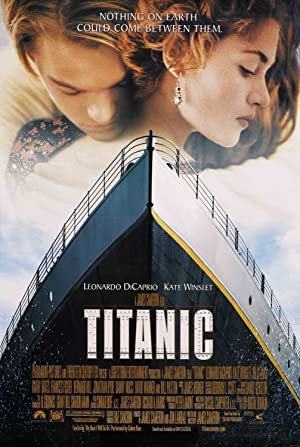

In [32]:
from IPython.display import Image
Image("Posters/Titanic.jpg")

#### Print the content of the local database, only single entry so far

In [33]:
print_database('movies.sqlite')

('Titanic', 1997, 194, 'United States, Mexico', 75.0, 7.9)


#### Search for 'Jumanji'

In [34]:
title = input('\nEnter the name of a movie (enter \'quit\' or hit ENTER to quit): ')
if len(title) < 1 or title=='quit': 
    print("Goodbye now...")
else:
    search_movie(title)

Goodbye now...


#### Search for "To kill a mockingbird"

In [35]:
title = input('\nEnter the name of a movie (enter \'quit\' or hit ENTER to quit): ')
if len(title) < 1 or title=='quit': 
    print("Goodbye now...")
else:
    search_movie(title)

Retrieving the data of "Titanic" now... 
--------------------------------------------------
Title: Titanic
Year: 1997
Rated: PG-13
Released: 19 Dec 1997
Runtime: 194 min
Genre: Drama, Romance
Director: James Cameron
Writer: James Cameron
Actors: Leonardo DiCaprio, Kate Winslet, Billy Zane
Plot: A seventeen-year-old aristocrat falls in love with a kind but poor artist aboard the luxurious, ill-fated R.M.S. Titanic.
Language: English, Swedish, Italian, French
Country: United States, Mexico
Awards: Won 11 Oscars. 125 wins & 83 nominations total
Ratings: [{'Source': 'Internet Movie Database', 'Value': '7.9/10'}, {'Source': 'Rotten Tomatoes', 'Value': '87%'}, {'Source': 'Metacritic', 'Value': '75/100'}]
Metascore: 75
imdbRating: 7.9
imdbVotes: 1,131,404
imdbID: tt0120338
--------------------------------------------------
c:\Users\Admin\Documents\GitHub\thebridge_ft_abr21\2-Data Analysis\PROF_11-APIs\teoria\OMDB/Posters/
Record already found. No update made.


#### Search for "Titanic" again, note while trying to save the record, the message from the database connection saying 'Record already found'

In [36]:
title = input('\nEnter the name of a movie (enter \'quit\' or hit ENTER to quit): ')
if len(title) < 1 or title=='quit': 
    print("Goodbye now...")
else:
    search_movie(title)

Retrieving the data of "To kill a mockingbird" now... 
--------------------------------------------------
Title: To Kill a Mockingbird
Year: 1962
Rated: Approved
Released: 16 Mar 1963
Runtime: 129 min
Genre: Crime, Drama
Director: Robert Mulligan
Writer: Harper Lee, Horton Foote
Actors: Gregory Peck, John Megna, Frank Overton
Plot: Atticus Finch, a widowed lawyer in Depression-era Alabama, defends a black man against an undeserved rape charge, and his children against prejudice.
Language: English
Country: United States
Awards: Won 3 Oscars. 14 wins & 16 nominations total
Ratings: [{'Source': 'Internet Movie Database', 'Value': '8.3/10'}, {'Source': 'Rotten Tomatoes', 'Value': '93%'}, {'Source': 'Metacritic', 'Value': '88/100'}]
Metascore: 88
imdbRating: 8.3
imdbVotes: 311,808
imdbID: tt0056592
--------------------------------------------------
c:\Users\Admin\Documents\GitHub\thebridge_ft_abr21\2-Data Analysis\PROF_11-APIs\teoria\OMDB/Posters/


#### Print the database contents again

In [38]:
print_database('movies.sqlite')

('Titanic', 1997, 194, 'United States, Mexico', 75.0, 7.9)
('To Kill a Mockingbird', 1962, 129, 'United States', 88.0, 8.3)


#### Save the database content into an Excel file

In [39]:
save_in_excel('test.xlsx','movies.sqlite')

In [40]:
import pandas as pd
df=pd.read_excel('test.xlsx')
df

,Unnamed: 0,Title,Year,Runtime,Country,Metascore,IMDBRating
0,0,Titanic,1997,194,"United States, Mexico",75,7.9
1,1,To Kill a Mockingbird,1962,129,United States,88,8.3
